# Tutorial: Plasmonic directional nanoantenna optimization - reload

Here we use [`pyGDM`](https://homepages.laas.fr/pwiecha/pygdm_doc) together with [`nevergrad`](https://facebookresearch.github.io/nevergrad/) to optimize a plasmonic nanoantenna for directional emission of an attached quantum emitter. This tutorial aims at reproducing the trends in [Wiecha et al. Opt. Express 27, pp. 29069, (2019)](https://doi.org/10.1364/OE.27.029069).

Here we reload the results calculated by the MPI-parallelized script.
The multiple optimization runs need to be done via MPI first.

Caution: pyGDM uses numba, as a result the MPI script uses pickle with some JIT-compiled numba objects to save the results. Reloading these objects requires to use the exactly same python installation as used for generation of the simulations, otherwise difficult to interpret errors can occur.

## Load modules

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

!pip install pyGDM2

from pyGDM2 import structures
from pyGDM2 import materials
from pyGDM2 import fields
from pyGDM2 import core
from pyGDM2 import propagators
from pyGDM2 import linear
from pyGDM2 import tools
from pyGDM2 import visu

## Preparation define geometry parametrization & cost functions

We start by defining the geometric model helper

In [2]:
def setup_structure(XY_coords_blocks, element_sim):
    """helper to create structure, from positions of gold elements
    each positions in units of discretization steps

    Args:
        XY_coords_blocks (list): list gold element positions (x1,x2,x3,...,y1,y2,....)
        element_sim (`pyGDM2.core.simulation`): single element simulation
        
    Returns:
        pyGDM2.structures.struct: instance of nano-geometry class
    """
    
    n = len(XY_coords_blocks) // 2
    x_list = XY_coords_blocks[:n]
    y_list = XY_coords_blocks[n:]
    pos = np.transpose([x_list, y_list])
    
    struct_list = []
    for _p in pos:
        x, y = _p
        # displace by steps of elementary block-size
        _s = element_sim.struct.copy()
        DX = _s.geometry[:, 0].max() - _s.geometry[:, 0].min() + _s.step
        DY = _s.geometry[:, 1].max() - _s.geometry[:, 1].min() + _s.step
        _s = structures.shift(_s, np.array([DX*int(x), DY*int(y), 0.0]))
        
        # do not add the block if too close to emitter at (0,0) 
        if np.abs(x) >= 1 or np.abs(y) >= 1:
            struct_list.append(_s)
    
    if len(struct_list) == 0:
        struct_list.append(_s + [DX, DY, 0])  # add at least one block
    
    full_struct = structures.combine_geometries(struct_list, step=element_sim.struct.step)
    full_sim = element_sim.copy()
    full_sim.struct = full_struct
    return full_sim


## Configure the nano-optics problem

Now we configure the simulation specifics:

 - the plasmonic building block geometry
 - the simulation conditions
 - the illumination

In [3]:
# ------- define main simulation
method = 'lu'  # simulations method: 'lu' --> CPU, 'cupy' --> GPU

## geometry: single small gold rectangle (20x20x10 nm^3)
step = 20
material = materials.gold()
geometry = structures.rect_wire(step, L=2, W=2, H=2)
geometry = structures.center_struct(geometry)
struct = structures.struct(step, geometry, material)

## environment: air
n1 = 1.0
dyads = propagators.DyadsQuasistatic123(n1=n1)


## illumination: local quantum emitter (dipole source)
field_generator = fields.dipole_electric    # light-source: dipolar emitter
kwargs = dict(x0=0, y0=0, z0=step,          # position: center, "steps" above surface
              mx=0, my=1, mz=0,             # orientation: Y
              R_farfield_approx=5000)       # use farfield approx. after 5microns
wavelengths = [800.]
efield = fields.efield(field_generator, wavelengths=wavelengths, kwargs=kwargs)

## simulation object of single element
element_sim = core.simulation(struct, efield, dyads)

structure initialization - automatic mesh detection: cube
structure initialization - consistency check: 8/8 dipoles valid


/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/tools.py:990: UserWarning: Mesh not detected, falling back to 'cubic'. mindist value = 8.974691772460938
  warnings.warn("Mesh not detected, falling back to 'cubic'. mindist value = {}".format(distsum))


## Reload saved optimization results

In [4]:
results = pickle.load(open('results_plasmonics_opt_directional_MPIrun.pkl', 'rb'))

## Sort re-loaded results


In [5]:
# init results container dict
list_optims = []
hist_cost = {}
hist_best_f = {}
hist_best_x = {}
for res in results:
    optim_name = res['optim_name']
    if not optim_name in hist_cost:
        list_optims.append(optim_name)
        hist_cost[optim_name] = []
        hist_best_f[optim_name] = []
        hist_best_x[optim_name] = 0


# iterate through results and keep best for each optimizer
for i, res in enumerate(results):
    #res = res[0]
    optim_name = res['optim_name']
    # add results of run to history
    hist_cost[optim_name].append(res['yval'])
    
    if hist_best_x[optim_name] == 0:
        hist_best_x[optim_name] = res['best_x']
    elif res['best_f'] < np.min(hist_best_f[optim_name]):
        hist_best_x[optim_name] = res['best_x']
    
    hist_best_f[optim_name].append(res['best_f'])

## Plot best structure from each algo

/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/tools.py:750: UserWarning: Duplicate meshpoints found! Removed 24 duplicates.
  warnings.warn("Duplicate meshpoints found! Removed {} duplicates.".format(len(geo_duplicate)))


timing for wl=800.00nm - setup: EE 2240.0ms, inv.: 235.9ms, repropa.: 316.5ms (1 field configs), tot: 2792.4ms


/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/visu.py:49: UserWarning: 3D data. Falling back to XY projection...
  warnings.warn("3D data. Falling back to XY projection...")
/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/visu.py:79: UserWarning: Mesh not detected, falling back to 'cubic'.
  warnings.warn("Mesh not detected, falling back to 'cubic'.")


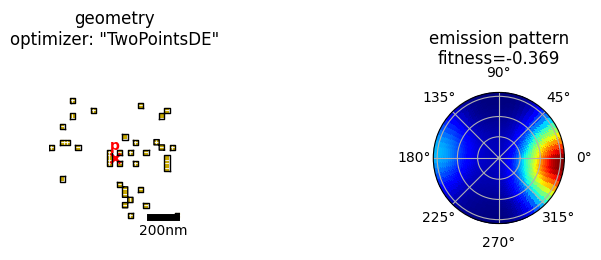

/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/tools.py:750: UserWarning: Duplicate meshpoints found! Removed 16 duplicates.
  warnings.warn("Duplicate meshpoints found! Removed {} duplicates.".format(len(geo_duplicate)))


timing for wl=800.00nm - setup: EE 8.3ms, inv.: 272.5ms, repropa.: 6.2ms (1 field configs), tot: 287.2ms


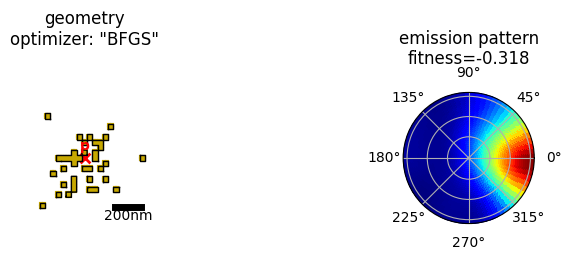

/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/tools.py:750: UserWarning: Duplicate meshpoints found! Removed 56 duplicates.
  warnings.warn("Duplicate meshpoints found! Removed {} duplicates.".format(len(geo_duplicate)))


timing for wl=800.00nm - setup: EE 6.9ms, inv.: 250.0ms, repropa.: 4.9ms (1 field configs), tot: 261.9ms


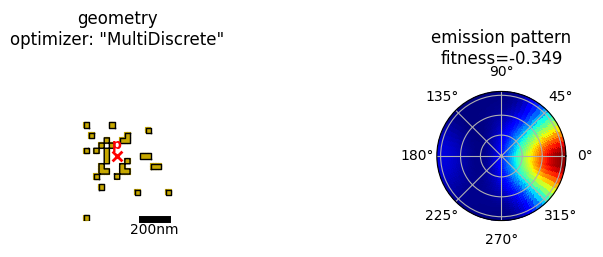

/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/tools.py:750: UserWarning: Duplicate meshpoints found! Removed 8 duplicates.
  warnings.warn("Duplicate meshpoints found! Removed {} duplicates.".format(len(geo_duplicate)))


timing for wl=800.00nm - setup: EE 8.5ms, inv.: 247.6ms, repropa.: 5.8ms (1 field configs), tot: 262.1ms


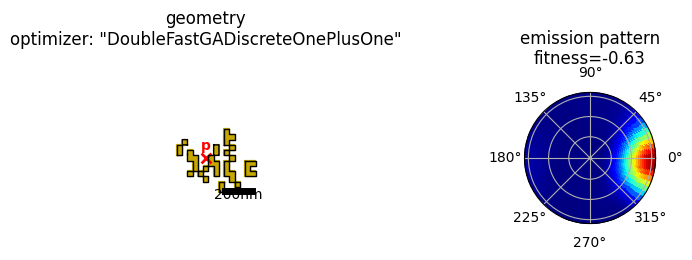

/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/tools.py:750: UserWarning: Duplicate meshpoints found! Removed 72 duplicates.
  warnings.warn("Duplicate meshpoints found! Removed {} duplicates.".format(len(geo_duplicate)))


timing for wl=800.00nm - setup: EE 6.2ms, inv.: 242.8ms, repropa.: 4.5ms (1 field configs), tot: 253.5ms


/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/visu.py:79: UserWarning: Mesh not detected, falling back to 'cubic'.
  warnings.warn("Mesh not detected, falling back to 'cubic'.")


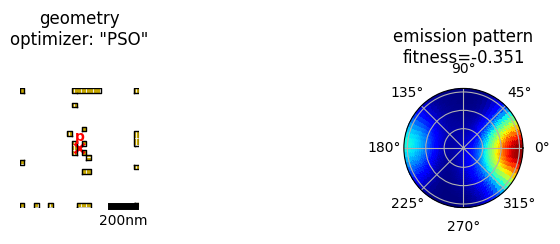

/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/tools.py:750: UserWarning: Duplicate meshpoints found! Removed 24 duplicates.
  warnings.warn("Duplicate meshpoints found! Removed {} duplicates.".format(len(geo_duplicate)))


timing for wl=800.00nm - setup: EE 9.9ms, inv.: 234.7ms, repropa.: 5.2ms (1 field configs), tot: 249.8ms


/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/visu.py:79: UserWarning: Mesh not detected, falling back to 'cubic'.
  warnings.warn("Mesh not detected, falling back to 'cubic'.")


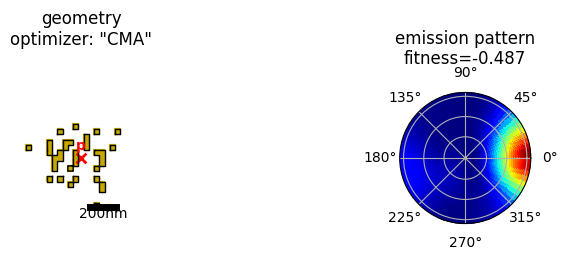

/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/tools.py:750: UserWarning: Duplicate meshpoints found! Removed 16 duplicates.
  warnings.warn("Duplicate meshpoints found! Removed {} duplicates.".format(len(geo_duplicate)))


timing for wl=800.00nm - setup: EE 8.0ms, inv.: 235.3ms, repropa.: 6.2ms (1 field configs), tot: 249.5ms


/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/visu.py:79: UserWarning: Mesh not detected, falling back to 'cubic'.
  warnings.warn("Mesh not detected, falling back to 'cubic'.")


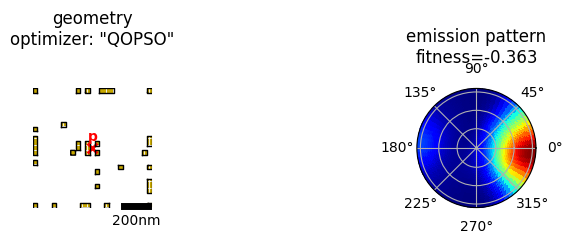

/home/pauline/miniconda3/lib/python3.11/site-packages/pyGDM2/tools.py:750: UserWarning: Duplicate meshpoints found! Removed 16 duplicates.
  warnings.warn("Duplicate meshpoints found! Removed {} duplicates.".format(len(geo_duplicate)))


timing for wl=800.00nm - setup: EE 8.7ms, inv.: 238.3ms, repropa.: 5.4ms (1 field configs), tot: 252.5ms


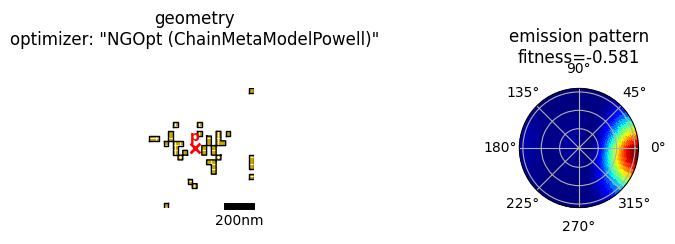

In [6]:
for i, optim_name in enumerate(list_optims):
    ## --- resimulate best individual
    x = hist_best_x[optim_name]
    f = np.min(hist_best_f[optim_name])
    sim = setup_structure(x.kwargs['x'], element_sim)
    sim.scatter(method=method)
    
    teta, phi, I_sc, I_tot, I0 = linear.farfield(
            sim, field_index=0,
            tetamin=0, tetamax=np.pi/2,
            Nteta=32, Nphi=72)
    
    
    ## --- plot
    plt.figure(figsize=(8,3))

    ## - structure geometry
    plt.subplot(121, aspect='equal')
    plt.title('geometry\noptimizer: "{}"'.format(optim_name), y =1.3)
    plt.axis('off')

    # structure
    visu.structure(sim, color='#c7a800', scale=1, show=False)
    visu.structure_contour(sim, color='k', show=False)
    # emitter position
    plt.text(sim.efield.kwargs['x0'], sim.efield.kwargs['y0']+20, 
                                        r"$\mathbf{p}$", ha='center', va='bottom', color='r')
    plt.scatter([sim.efield.kwargs['x0']], [sim.efield.kwargs['y0']],
                                        marker='x', linewidth=2, s=50, color='r')
    # scale bar
    bnds = [sim.struct.geometry.T[0].max(), sim.struct.geometry.T[1].min(), sim.struct.geometry.T[1].max()]
    plt.text(bnds[0]-120, bnds[1] - 0.18*(bnds[2]-bnds[1]), 
             "200nm", ha='center', va='bottom')
    plt.plot([bnds[0]-220, bnds[0]-20], 
             [bnds[1], bnds[1]], lw=5, color='k', clip_on=False)
    plt.xlim(-500,500)
    plt.ylim(-500,500)
    ## - emission pattern
    plt.subplot(122, polar=True)
    plt.title("emission pattern\nfitness={:.3g}".format(f), x=0.5, y=1.15)
    im = visu.farfield_pattern_2D(teta, phi, I_tot,
                              cmap='jet', degrees=False, show=False)
    plt.gca().set_yticklabels([])

    plt.tight_layout()
    plt.show()

## Convergence plots

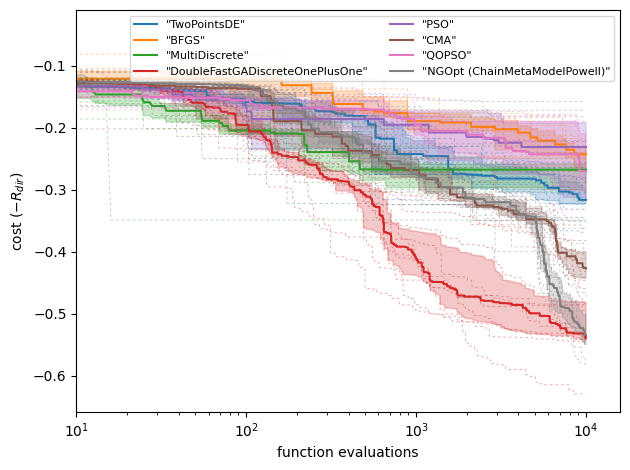

In [7]:
colors = [f'C{i}' for i in range(10)]

for i_opt, k in enumerate(hist_cost):
    for i, convergence in enumerate(hist_cost[k]):
        plt.plot(convergence, color=colors[i_opt], lw=0.5, alpha=0.5, dashes=[4,4])
    
    plt.plot(np.median(hist_cost[k], axis=0), color=colors[i_opt], label=f'"{k}"')
    plt.fill_between(np.arange(len(hist_cost[k][0])), 
                     np.quantile(hist_cost[k], 0.25, axis=0), 
                     np.quantile(hist_cost[k], 0.75, axis=0), 
                     color=colors[i_opt],
                     alpha=0.25)

plt.xscale('log'); plt.xlim(10, plt.xlim()[1])

plt.xlabel('function evaluations')
plt.ylabel('cost ($-R_{dir}$)')
plt.legend(ncol=2, fontsize=8)

plt.tight_layout()
plt.show()

## Plot the consistency test

Compare results of multiple runs

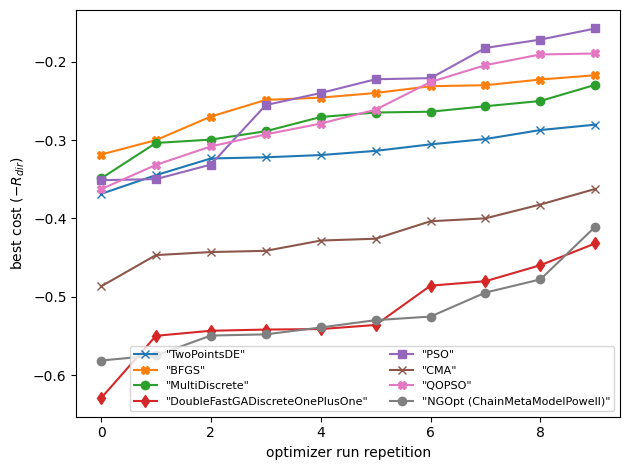

In [8]:
colors = [f'C{i}' for i in range(10)]
markers = ['x', 'X', 'o', 'd', 's'] * 2

for i_opt, k in enumerate(hist_best_f):
    plt.plot(np.sort(hist_best_f[k]), color=colors[i_opt], marker=markers[i_opt], label=f'"{k}"')
    
plt.xlabel('optimizer run repetition')
plt.ylabel('best cost ($-R_{dir}$)')

plt.legend(ncol=2, fontsize=8)
plt.tight_layout()
plt.show()